# A notebook to visualize each of the code fragments

## 1. Imports 
In order to access the functions in `src`, we add the repository path to our sys path. 

In [3]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


repo_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(repo_path)

import src

## 2. Create some demo data

We choose one variable of the lorenz system with noise and some artificially missing values.

In [20]:
# Create data

def lorenz(state, t, sigma, rho, beta):
    # unpack the state vector
    x, y, z = state
    # compute state derivatives
    xd = sigma * (y - x)
    yd = (rho - z) * x - y
    zd = x * y - beta * z
    # return the state derivatives
    return [xd, yd, zd]

dt_sec = 0.02 # Time step in seconds
T = 2000 # Total time in seconds
discard_T = 100 # Time in seconds to discard in the beginning
T_total = T + discard_T
state0 = np.array([-8, -8, 27]) # Initial state
t = np.linspace(0, T_total, int(T_total / dt_sec))  # the times in seconds to simulate 
sigma, rho, beta = 10, 28, 8 / 3  # default lorenz-parameters
data = np.array(odeint(lorenz, state0, t, args=(sigma, rho, beta)), dtype=np.float64)[int(discard_T / dt_sec):, [0]]
np.random.seed(333)
data += np.random.randn(*data.shape) * 2.0 # Add some gaussian noise. 

# Add some missing values to simulate real missing values in the data: 
percent_missing = 0.01  # 1% missing values
num_missing = int(data.shape[0] * percent_missing)
# Generate random indices to make missing
missing_indices = np.random.choice(data.shape[0], num_missing, replace=False)

# Make those values missing
data = data.copy()
data[missing_indices] = np.nan

print(f"{data.shape=}")

data.shape=(100000, 1)


Text(0.5, 1.0, 'section sample data')

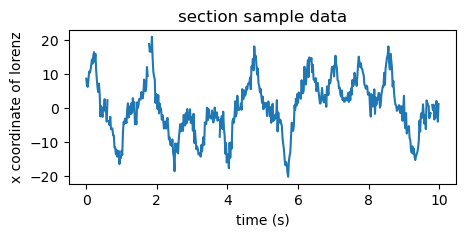

In [21]:
# Visualize the data 
t_start_sec = 0
t_end_sec = 10
start_frame = int(t_start_sec / dt_sec)
end_frame = int(t_end_sec / dt_sec)

plt.figure(figsize=(5, 2))
plt.plot(t[start_frame:end_frame], data[start_frame:end_frame])
plt.xlabel("time (s)")
plt.ylabel("x coordinate of lorenz")
plt.title("section sample data")

## 3. Time-Delay embedding

Let's demonstrate the `src.mps.time_delay_embedding` module. To be able to handle missing values in a better way than just having `np.nan` for some elements, let's use masked arrays. When choosing `masked_array=True`, the returned time-delayed data is a masked array. 

In [32]:
# See the effect of time-delay embedding with different delay-embedding dimensions k

for k in [1, 2, 3]:  # Use k to define the delay-embedding dimension
    delay = k - 1 # The delay is given by k - 1. 
    
    # Get the time-delayed data
    data_td = src.mps.time_delay_embedding.time_delay_embedding(data, delay=delay, masked_array=True)
    print(f"\n{k=}")
    print(f"{data_td.shape=}")


k=1
data_td.shape=(100000, 1)

k=2
data_td.shape=(99999, 2)

k=3
data_td.shape=(99998, 3)


Text(0.5, 1.0, 'time-delay embedded data with k=3')

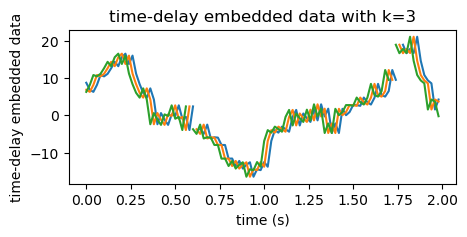

In [34]:
# Let's visualize the 3 dimensions of after time-delay embedding

k = 3
delay = k - 1
data_td = src.mps.time_delay_embedding.time_delay_embedding(data, delay=delay, masked_array=True)

t_start_sec = 0
t_end_sec = 2
start_frame = int(t_start_sec / dt_sec)
end_frame = int(t_end_sec / dt_sec)
plt.figure(figsize=(5, 2))
plt.plot(t[start_frame:end_frame], data_td[start_frame:end_frame])
plt.xlabel("time (s)")
plt.ylabel("time-delay embedded data")
plt.title(f"time-delay embedded data with {k=}")

Do `reverse_time_delay_embedding` to recover the original data. You can see the `recovered_data` is now a masked array, but the values are the same as in `data`.

In [38]:
# Use reverse time delay embedding to recover the original time-series
k = 2
delay = k - 1

data_td = src.mps.time_delay_embedding.time_delay_embedding(data, delay=delay, masked_array=True)
recovered_data = src.mps.time_delay_embedding.reverse_time_delay_embedding(data_td, delay=delay, masked_array=True)

print(f"{data[:3, 0]=}")
print(f"{recovered_data[:3, 0]=}")

data[:3, 0]=array([8.70186055, 6.81821843, 6.26342492])
recovered_data[:3, 0]=masked_array(data=[8.701860553425103, 6.818218427091901,
                   6.2634249234479595],
             mask=[False, False, False],
       fill_value=1e+20)


## 4.Clustering

The next step in the maximally predictive state scheme is to cluster the time-delayed data using kmeans clustering. 

In [45]:
n_clusters = 100

# Do kmeans clustering
labels, cluster_centers, model = src.mps.clustering.cluster_data(data_td, 
                                                                 n_clusters=n_clusters, 
                                                                 random_state=42, 
                                                                 return_centers=True)

print(f"{data_td.shape=}")
print(f"{labels.shape=}")
print(f"{cluster_centers.shape=}")

data_td.shape=(99999, 2)
labels.shape=(99999,)
cluster_centers.shape=(100, 2)


Every time-step in the time-delayed data `data_td` was now assigned to a discrete label. `labels` corresponds to the time series of these labels. There are as many different labels as there are clusters `n_clusters`. 

Text(0.5, 1.0, 'time series of labels with k=2, n_clusters=100')

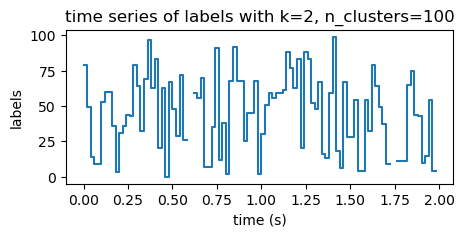

In [52]:
# Plot the time series of labels

t_start_sec = 0
t_end_sec = 2
start_frame = int(t_start_sec / dt_sec)
end_frame = int(t_end_sec / dt_sec)
plt.figure(figsize=(5, 2))
plt.step(t[start_frame:end_frame], labels[start_frame:end_frame])
plt.xlabel("time (s)")
plt.ylabel("labels")
plt.title(f"time series of labels with {k=}, {n_clusters=}")

Using the cluster centers (`cluster_centers`) we can reconstruct the time-delayed data (with a loss of information) and compare it to the original data_td. 

data_td_recon.shape=(99999, 2)
data_td.shape=(99999, 2)


Text(0.5, 1.0, 'reconstructed td-data vs. true')

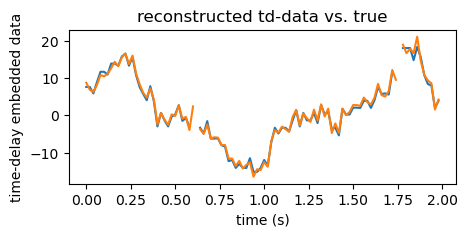

In [56]:
data_td_recon = src.mps.clustering.reconstruct(labels=labels, cluster_centers=cluster_centers)

print(f"{data_td_recon.shape=}")
print(f"{data_td.shape=}")

# plot it 
t_start_sec = 0
t_end_sec = 2
start_frame = int(t_start_sec / dt_sec)
end_frame = int(t_end_sec / dt_sec)
plt.figure(figsize=(5, 2))
plt.plot(t[start_frame:end_frame], data_td_recon[start_frame:end_frame, 0])
plt.plot(t[start_frame:end_frame], data_td[start_frame:end_frame, 0])
plt.xlabel("time (s)")
plt.ylabel("time-delay embedded data")
plt.title(f"reconstructed td-data vs. true")